# Data Science Workshop Project
**Team:** Elad Bilman, Oz Hizkia, Eva Hallermeier, Tzach Cohen

**Problem:** The prediction of in-hospital mortality for admitted patients remain poorly characterized and is biased by
             Doctor's opinion.

**Goal of the project**: We aimed to develop and validate a prediction model for all-cause in-hospital mortality among
                         admitted patients.

## Part 1 - Prologue
### Dataset: Patient Survival Prediction

We choose a dataset from Kaggle  https://www.kaggle.com/datasets/mitishaagarwal/patient

This dataset is a collection of patients that visited the ICU in an hospital. Each row represents a patient, <br>
which in itself is a collection of checkups of the patient 1 hour after his reception and 1 day after his reception, <br>
among other medical examinations. The data also includes the basic characeristics of the patient such as gender, <br>
ethnicity, etc.



#### Import Modules, Libraries and Functions

In [74]:
%matplotlib inline

# Data Processing
import pandas as pd
import numpy as np

# Machine Learning Library
import sklearn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Analyze Model Tools
import shap
from sklearn.metrics import confusion_matrix

# Visualization Tools
import matplotlib.pylab as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

from DataprocessingMethods import *
from Model.FinalModel import FinalModel
from Model.ModelModule import DSWorkshopModel
from MissingValuesVisualization import *

# QOL Functions
from UsefullFunctions import load_dataset

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [75]:
# Load Original Dataset
df = load_dataset()
df.head() # Overview of the dataset.

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0


The dataset is composed of 85 columns (features) and we have 91,713 patients. <br> 
We can see that we have an entire empty column (index=83) that we will remove.

## Part 2 - Understanding The Dataset

We have different types of feature: numerical, categorical and binary. Some of the features are data about <br> the medical measures of the patient and some are description of hospital unit and cares he received. <br>

<span style='background:#5c97ff;color:Black'>
In addition, we wrote a complete file which explains all medical features.
</span>

In [76]:
categorial_features = ["hospital_id", "ethnicity", "gender", "icu_admit_source", 
                       "apache_3j_bodysystem", "apache_2_bodysystem", "icu_stay_type", "icu_type"]

numerical_features = ["age", "bmi","height", "weight", 
                      "pre_icu_los_days", "gcs_eyes_apache","apache_2_diagnosis",
                      "gcs_motor_apache", "gcs_verbal_apache", "heart_rate_apache",
                     "map_apache", "resprate_apache", "temp_apache", "d1_diasbp_max",
                      "d1_diasbp_min","d1_diasbp_noninvasive_max", "d1_diasbp_noninvasive_min",
                      "d1_heartrate_max", "d1_heartrate_min", "d1_mbp_max", "d1_mbp_min", 
                      "d1_mbp_noninvasive_max", "d1_mbp_noninvasive_min", "d1_resprate_max", 
                      "d1_resprate_min","d1_spo2_max", "d1_spo2_min", "d1_sysbp_max", "d1_sysbp_min",
                      "d1_sysbp_noninvasive_max", "d1_sysbp_noninvasive_min", "d1_temp_max", 
                      "d1_temp_min","h1_diasbp_max", "h1_diasbp_min", "h1_diasbp_noninvasive_max", 
                      "h1_diasbp_noninvasive_min","h1_heartrate_max", "h1_heartrate_min", 
                      "h1_mbp_max", "h1_mbp_min","h1_mbp_noninvasive_max", "h1_mbp_noninvasive_min",
                      "h1_resprate_max", "h1_resprate_min","h1_spo2_max", "h1_spo2_min", 
                      "h1_sysbp_max", "h1_sysbp_min","h1_sysbp_noninvasive_max", 
                      "h1_sysbp_noninvasive_min", "d1_glucose_max", "d1_glucose_min",
                      "d1_potassium_max", "d1_potassium_min", "apache_4a_hospital_death_prob", 
                      "apache_4a_icu_death_prob","apache_3j_diagnosis"]


binary_features = ["arf_apache", "gcs_unable_apache", "intubated_apache", 
                   "ventilated_apache", "elective_surgery", "apache_post_operative",
                   "aids", "cirrhosis", "diabetes_mellitus", "hepatic_failure", "immunosuppression",
                   "leukemia", "lymphoma", "solid_tumor_with_metastasis"]

### Part 2.1 - The Problem

**Info About the Prediction Problem:** <br>
We chose to classify wether the patient will "go into very critical state" or not as the dataset have a fetaure of wether the <br>
patient is alive or not.
So our problem is binary classification, if the patient is alive it's marked as 0, otherwise 1.

### Part 2.2 - Thankfully Unbalanced Dataset

([<matplotlib.patches.Wedge at 0x20d18807940>,
 [Text(-1.0598172020063896, 0.294597179774939, '0'),
  Text(1.0598172295885635, -0.2945970805476902, '1')],
 [Text(-0.5780821101853033, 0.16068937078633036, '91.4%'),
  Text(0.5780821252301255, -0.16068931666237643, '8.6%')])

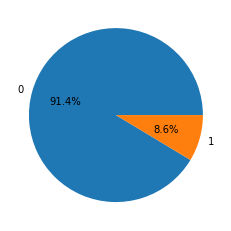

In [77]:
class_prediction = "hospital_death"
unique_labels = np.unique(df[class_prediction])
plt.pie(np.array([len(df[df[class_prediction]==label]) for label in unique_labels ]), 
        labels = list(unique_labels), autopct='%1.1f%%')

As we can see, the difference in quantity of the two classes is exceptionally large, <br>
with the label '1' being far less common. <br>
Due to that, it will be a challenge for the model to predict the label '1', which represents cases that ended <br>
with patients' death.

As such we face the challenge of keeping the model from being biased, since most of the data is labeled with '0' <br>
which will cause the model to easily predict this label, but not the other.

## Part 4 - Sanitizing and Organizing the Dataset
### Part 4.1 - Missing Data

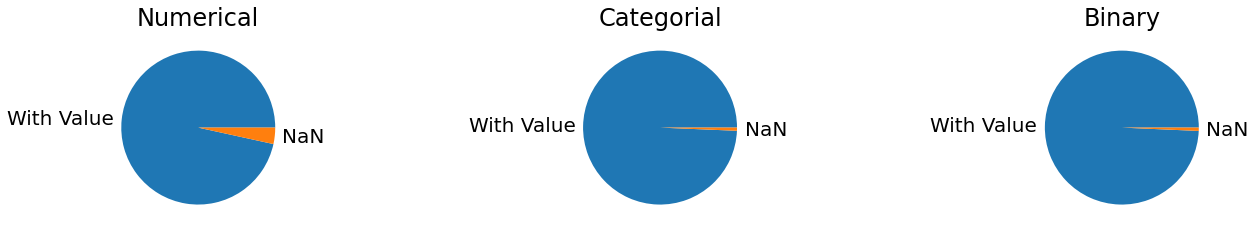

In [78]:
visualizeMissingValues(df)

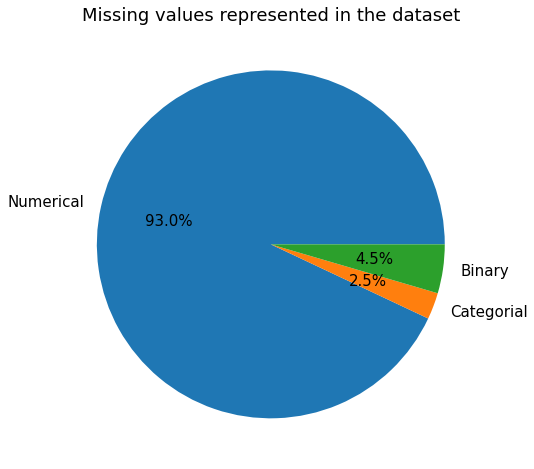

In [79]:
missingValuesDistribution(df)

<span style='background:#ffd500;color:Black'> Most of missing values are numerical. </span>


In [80]:
df.drop(df.columns[[0,1,83]], axis=1, inplace=True) # Remove useless column

In [81]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
featuresWithManyMissingValues = missing_value_df.sort_values(by='percent_missing',ascending=False).head(25)
featuresWithManyMissingValues.head(15)

,column_name,percent_missing
d1_potassium_max,d1_potassium_max,10.451081
d1_potassium_min,d1_potassium_min,10.451081
h1_mbp_noninvasive_min,h1_mbp_noninvasive_min,9.904812
h1_mbp_noninvasive_max,h1_mbp_noninvasive_max,9.904812
apache_4a_hospital_death_prob,apache_4a_hospital_death_prob,8.665075
apache_4a_icu_death_prob,apache_4a_icu_death_prob,8.665075
h1_diasbp_noninvasive_min,h1_diasbp_noninvasive_min,8.014131
h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_max,8.014131
h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_max,8.004318
h1_sysbp_noninvasive_min,h1_sysbp_noninvasive_min,8.004318


### Part 4.2 - Deal With Missing Values:
- For Categorical values:
    - We will do one hot encoding so we would not need to deal with missing values. <br>
    We wouldn't include in the clean dataset cells with no categorial match and put a meaningless value.
- For Numerical values:
    - We will fill the cells with the mean of the feature taken <span style='color: #ff0000'> ONLY </span> from the test.
- For Binary values: 
    - We will fill missing values with 0 because most of binary values tell if a patient was given a specific problem <br>
    or a specific treatment, we will assume that if its not written that it hasn't happened.

### Part 4.3 - Informative Data Visualization## 5- Data visualization

#### Feature Distribution

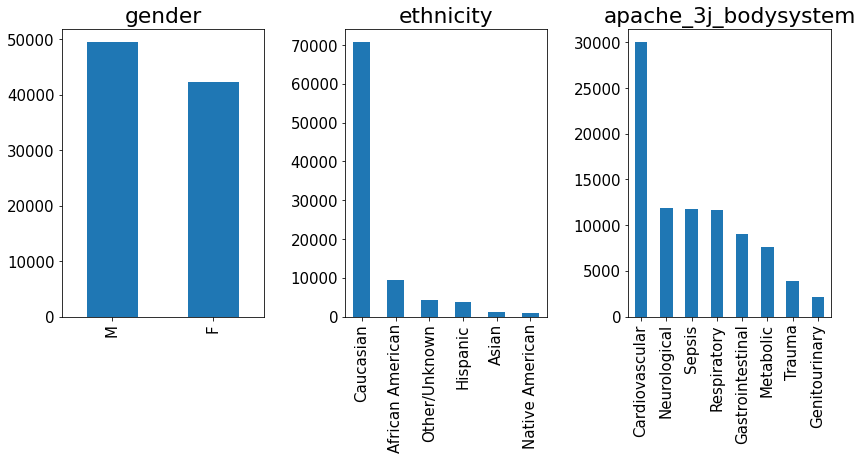

In [82]:
# Histograms of interesting categorical feature: gender, ethnicity and admission diagnoosis (type of health problem)

columns =  ["gender", "ethnicity","apache_3j_bodysystem"]
fig, axes = plt.subplots(1,3,figsize=(12,5))

n=len(columns)
num_rows = 1
max_bars = 8

for i,variable in enumerate(columns):
    u=min(df[variable].nunique(),max_bars)
    vc = df[variable].value_counts()[:u]
    plt.rcParams.update({'font.size': 18})
    vc.plot(kind='bar',ax=axes[i],title=variable)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.99, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

#### Influence of the Age of the Patient on Hospital Death

We know that older patient are at a bigger risk of complications and we can see it clearly on this graph. <br>
The number of deaths is bigger for older patients. <br>
In natural correlation we will also see in the model examination that age is a <b>very</b> important feature.

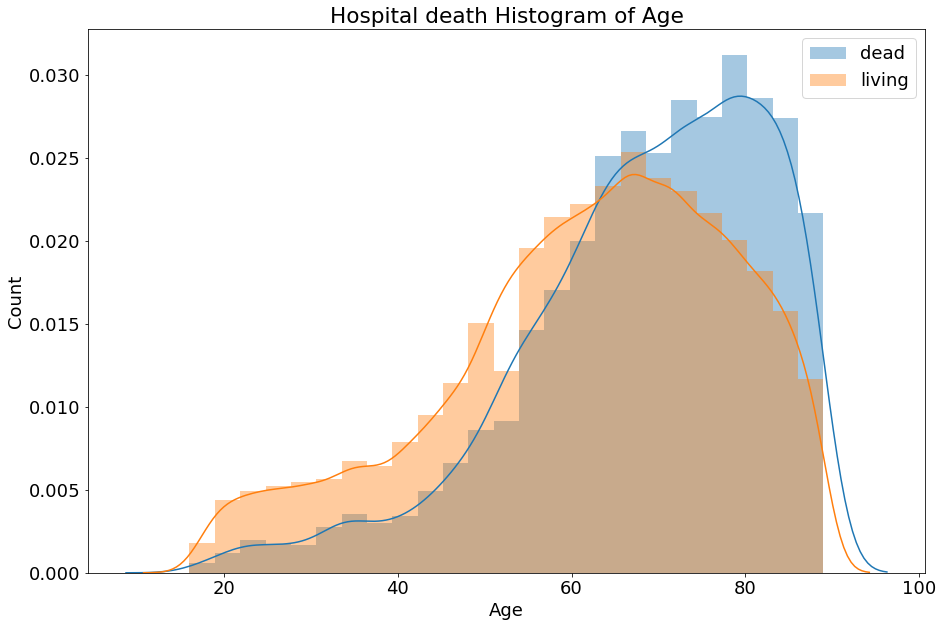

In [83]:
dead_patient = df[df["hospital_death"] == 1]
living_patient = df[df["hospital_death"] == 0]

fig,ax=plt.subplots(figsize=(15,10))

#create two histograms
sns.distplot(dead_patient.age, bins = 25, kde = True, label = "dead",ax=ax)
sns.distplot(living_patient.age, bins = 25, kde = True, label = "living",ax=ax)

plt.title('Hospital death Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(loc="upper right")

In [84]:
df = getBasicDataset()
#prepare data
x_data = df.drop('hospital_death', axis=1)
true_values = df.hospital_death
x_train, x_test, y_train, y_test = train_test_split(x_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)
x_train = fill_missing_num_values_with_mean(x_train)
x_train = fill_missing_values_binary(x_train)
x_test = fill_test_missing_num_values_with_mean(x_test,x_train)
x_test = fill_test_missing_values_binary(x_test, x_train)

all_data = pd.concat([x_train, x_test], axis=0)

## Part 6 - Running Naive Model <br> for Baseline Results and Performance Analysis

We tested a few basic models:
- Random Forest
- Extra Trees
- XGBoost

We get the best result from the XGBoost so we decided to stick with it for our advanced model.
<br>See the basic results:

In [85]:
#init model
model = DSWorkshopModel(df) 
model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

#train mondel
model.train()

#test model
models_predictions, pred_results = model.test()

#results
print(pred_results)

          Method  Precision Score  Recall Score  F1 Score  \
0  XGBClassifier         0.640719      0.337966  0.442514   

   Unbalanced Accuracy Score  Balanced Accuracy Score  \
0                   0.926511                 0.660033   

   Positive Accuracy Score  Negative Accuracy Score Time Needed for Training  
0                  0.33797                   0.9821                   43.34s  


Because we have an unbalanced model we will use "Balanced Accuracy" and "Recall" as our "guiding" metrics.

*Note: Balanced Accuarcy is like the Accuracy metric but the skewness of the metrics.

**Result of the basic model as baseline:**
- Recall around (positive accuracy) 33% so many false negative
- Precision around  67%
- Global Accuracy 93%
- Balanced accuracy around 65%
- Negative accuracy around 98 % 

Because we have only around 10% of death cases in our dataset it means that if we have 90% accuracy <br>
thus we probably always give 0 as prediction let's, verify it.

In [86]:
def conf_matrix(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

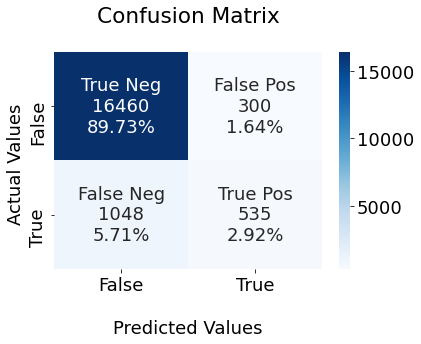

In [87]:
cf_matrix = confusion_matrix(y_test.to_numpy(), models_predictions[-1])
conf_matrix(cf_matrix)

As predicted the biggest problem is that we have too much false negative so our goal will be to reduce it.
We will prefer to predict death in order that a patient in danger will receive more attention and intensive care which maybe can save him.

### Analyze performance of the model
#### Precision recall curve: 
Precision-Recall curves should be used when there is a moderate to large class imbalance.

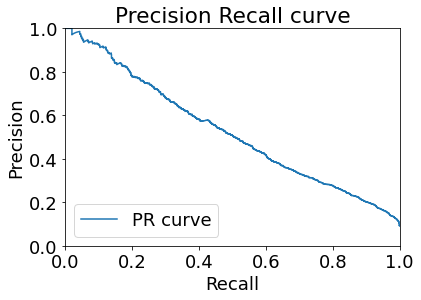

In [88]:
y_true = y_test
xgb = model.get_models()[0] #xgboost
predicted_probs = xgb.predict_proba(x_test)
y_score = predicted_probs[:,1]

def plotPR(precision, recall):
    plt.figure()
    plt.plot(recall, precision, label='PR curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall curve')
    plt.legend(loc='lower left')
    plt.show()
    
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score, pos_label=1)
plotPR(precision, recall)

#### ROC curve
ROC curves should be used when there are roughly equal numbers of observations for each class which is not our case.

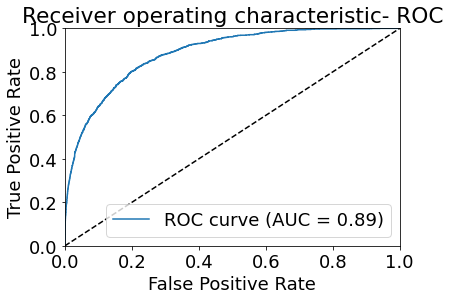

In [89]:
def plotRoc(fpr, tpr, auc):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic- ROC')
    plt.legend(loc="lower right")
    plt.show()

auc = sklearn.metrics.roc_auc_score(y_true, y_score)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
plotRoc(fpr, tpr, auc)

### SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


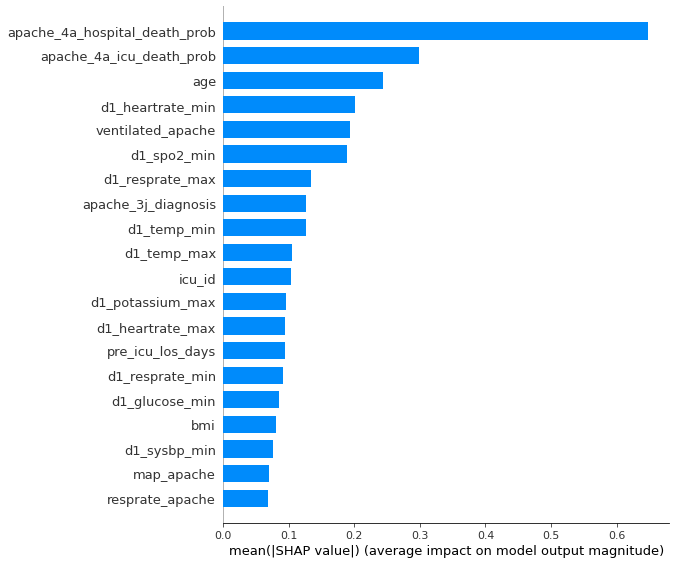

In [90]:
shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(all_data)

#feature importance analysis
shap.summary_plot(shap_values, all_data, plot_type="bar")

We can see here clearly here which feature have the biggest influence on the prediction of the model.

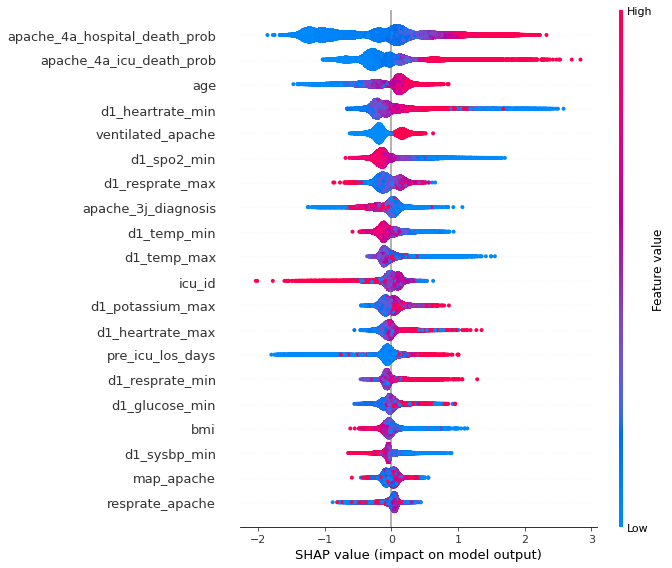

In [91]:
shap.summary_plot(shap_values, all_data)

## 7- Improvement of the naive model

### 7.1 Oversampling: make training set more balanced

In [92]:
df = getBasicDataset()

#prepare data
x_data = df.drop('hospital_death', axis=1)
true_values = df.hospital_death
x_train, x_test, y_train, y_test = train_test_split(x_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)
x_train = fill_missing_num_values_with_mean(x_train)
x_train = fill_missing_values_binary(x_train)
x_test = fill_test_missing_num_values_with_mean(x_test,x_train)
x_test = fill_test_missing_values_binary(x_test, x_train)

oversample = RandomOverSampler(sampling_strategy='minority')
x_np = x_train.to_numpy()
y_np = y_train.to_numpy()
x_np, y_np = oversample.fit_resample(x_np, y_np)
# Convert back to pandas
x_train = pd.DataFrame(x_np, columns=x_train.columns)
y_train = pd.Series(y_np, name=y_train.name)


model = FinalModel(df)
model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

#train mondel
model.train()

#test model
models_predictions, pred_results = model.test()

#results
print(pred_results)

          Method  Precision Score  Recall Score  F1 Score  \
0  XGBClassifier         0.216821      0.825648   0.34345   

   Unbalanced Accuracy Score  Balanced Accuracy Score  \
0                    0.72758                 0.771982   

   Positive Accuracy Score  Negative Accuracy Score Time Needed for Training  
0                  0.82565                  0.71832                   92.43s  


**Result of the basic model as baseline:**
- Recall around (positive accuracy) 81% and was 33% in the basic model!
- Balanced accuracy around 77 % and was around 65% in the basic model!
- Negative accuracy and unbalanced accuracy (normal one) decrease


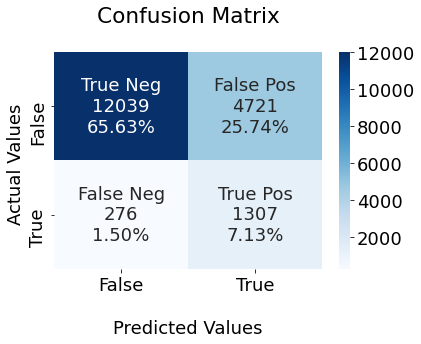

In [93]:
cf_matrix = confusion_matrix(y_test.to_numpy(), models_predictions[-1])
conf_matrix(cf_matrix)

We can say now that we now predict better death cases which was our goal.

### SHAP on the new model

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


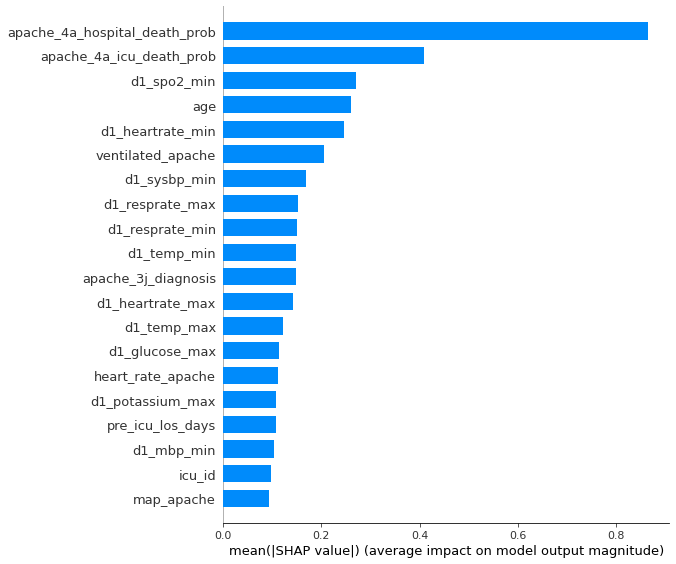

In [94]:
y_true = y_test
all_data = pd.concat([x_train, x_test], axis=0)
xgb = model.get_models()[0] #xgboost
predicted_probs = xgb.predict_proba(x_test)
shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(all_data)

#feature importance analysis
shap.summary_plot(shap_values, all_data, plot_type="bar")

We can see here that the two most important features : apache4a_hospital_deathprob and apache4a_icudeath_prob  have same meaning so let s try to analyze them and maybe try to remove one of them in order to have a simpler dataset and it also can be easier for the model and maybe we can get better results of the model.

In [72]:
df = getBasicDataset()

#they have same quantity of missing values (based on our previous missing value analysis)
#We would like to check if missing values are for same patients
counter = 0

for idx,row in df.iterrows():
    if pd.isnull(row["apache_4a_hospital_death_prob"]) and pd.isnull(row["apache_4a_icu_death_prob"]):
        counter+=1

print((counter/df.shape[0])*100)

8.665074744038467


This value is equal to total number of missing values in each one so yes we have missing values for same patients for those both features. Lets now try to check if they have same values or really close: if yes we don t need both of them and we will keep only one: the one that will get better performance. 

In [95]:
counter = 0

for idx,row in df.iterrows():
    if abs(row["apache_4a_hospital_death_prob"] - row["apache_4a_icu_death_prob"])<0.15:
        counter+=1

print((counter/df.shape[0])*100)

85.28234819491239


85% of those values are really close. We can see that most of values for those feature are really close so it means that we don t really need both of them so let s try to run model with only one of them.

In [ ]:
df[["apache_4a_hospital_death_prob","apache_4a_icu_death_prob"]].dropna().corr()

We can see also that we have as expected high correlation between them

### Run with only "apache_4a_icu_death_prob"

In [98]:
df = getBasicDataset()
df = df.drop('apache_4a_hospital_death_prob', axis=1)
#prepare data
x_data = df.drop('hospital_death', axis=1)
true_values = df.hospital_death
x_train, x_test, y_train, y_test = train_test_split(x_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)
x_train = fill_missing_num_values_with_mean(x_train)
x_train = fill_missing_values_binary(x_train)
x_test = fill_test_missing_num_values_with_mean(x_test,x_train)
x_test = fill_test_missing_values_binary(x_test, x_train)

oversample = RandomOverSampler(sampling_strategy='minority')
x_np = x_train.to_numpy()
y_np = y_train.to_numpy()
x_np, y_np = oversample.fit_resample(x_np, y_np)
# Convert back to pandas
x_train = pd.DataFrame(x_np, columns=x_train.columns)
y_train = pd.Series(y_np, name=y_train.name)


model = FinalModel(df)
model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

#train mondel
model.train()

#test model
models_predictions, pred_results = model.test()

#results
print(pred_results)

          Method  Precision Score  Recall Score  F1 Score  \
0  XGBClassifier         0.211857      0.814908  0.336288   

   Unbalanced Accuracy Score  Balanced Accuracy Score  \
0                   0.722401                 0.764286   

   Positive Accuracy Score  Negative Accuracy Score Time Needed for Training  
0                  0.81491                  0.71366                  129.78s  


### Run with only "apache_4a_hospital_death_prob"

In [99]:
df = getBasicDataset()
df =df.drop('apache_4a_icu_death_prob',axis=1)
#prepare data
x_data = df.drop('hospital_death', axis=1)
true_values = df.hospital_death
x_train, x_test, y_train, y_test = train_test_split(x_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)
x_train = fill_missing_num_values_with_mean(x_train)
x_train = fill_missing_values_binary(x_train)
x_test = fill_test_missing_num_values_with_mean(x_test,x_train)
x_test = fill_test_missing_values_binary(x_test, x_train)

oversample = RandomOverSampler(sampling_strategy='minority')
x_np = x_train.to_numpy()
y_np = y_train.to_numpy()
x_np, y_np = oversample.fit_resample(x_np, y_np)
# Convert back to pandas
x_train = pd.DataFrame(x_np, columns=x_train.columns)
y_train = pd.Series(y_np, name=y_train.name)


model = FinalModel(df)
model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

#train mondel
model.train()

#test model
models_predictions, pred_results = model.test()

#results
print(pred_results)

          Method  Precision Score  Recall Score  F1 Score  \
0  XGBClassifier         0.218313      0.838913  0.346465   

   Unbalanced Accuracy Score  Balanced Accuracy Score  \
0                   0.726871                 0.777601   

   Positive Accuracy Score  Negative Accuracy Score Time Needed for Training  
0                  0.83891                  0.71629                   89.12s  


We get better performance with only "apache_4a_hospital_death_prob" so we will remove for next trials the feature "apache_4a_icu_death_prob"

## 7.2 Oversampling with arrangement of data based on importance of features

Lets try to check which features have  an important impact on the model and have many missing values filed which can give bad data to the model.We will build list of features with high importance and many missing values and we will analyze them and decide how to represent them is the dataset.

In [23]:
featuresWithManyMissingValues = featuresWithManyMissingValues[['column_name']]

vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(all_data.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

In [24]:
most_important_feature = feature_importance['col_name'].tolist()
featuresWithManyMissingValues = featuresWithManyMissingValues['column_name'].tolist()
set1 = set(most_important_feature)
set2 = set(featuresWithManyMissingValues)
newList = list(set1.intersection(set2))
print("Important features with many missing data originally are:\n", newList)

Intersection of the lists is: ['h1_spo2_max', 'h1_sysbp_min', 'd1_glucose_max', 'h1_resprate_min', 'h1_diasbp_noninvasive_min', 'd1_potassium_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'age', 'h1_diasbp_max', 'temp_apache', 'h1_mbp_min', 'apache_4a_icu_death_prob', 'h1_mbp_max', 'h1_resprate_max', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'd1_potassium_min', 'd1_glucose_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'apache_4a_hospital_death_prob', 'bmi', 'h1_spo2_min', 'h1_sysbp_max']


About the feature h1_spo2_max and 'h1_spo2_min': it about saturation: percentage of oxygene in the blood: someone in good health has around 100 % and someone which have pulmonary or very sick can have between 80 and 95%. Lets check the distribution of the data.

In [41]:
df = getBasicDataset()

dfspo2max = df['h1_spo2_max'].mean()
print("mean 'h1_spo2_max' is ", dfspo2max)
dfspo2min = df['h1_spo2_min'].mean()
print("mean 'h1_spo2_min' is ", dfspo2min)


mean 'h1_spo2_max' is  98.04463714468513
mean 'h1_spo2_min' is  95.17430993510648


For those features for saturation we check that mean of saturation based on dataset are ok for filling missing values because normal saturation is higher than around 96% so we can say that maximum can be 98 % and minimum 95 % : those values are acceptable.

About d1_potassium_max and d1_potassium_min: let s try to make the same analysis

In [49]:
df = getBasicDataset()

dfspo2max = df['d1_potassium_max'].mean()
print("mean 'd1_potassium_max' is ", dfspo2max)
dfspo2min = df['d1_potassium_min'].mean()
print("mean 'd1_potassium_min' is ", dfspo2min)

mean 'd1_potassium_max' is  4.251594462302717
mean 'd1_potassium_min' is  3.934658338203785


6.58       1
4.29       1
4.27       1
3.68       1
5.37       1
6.01       1
4.46       1
4.52       1
4.63       1
5.07       1
4.48       1
3.78       1
5.28       1
5.05       1
3.62       1
3.97       1
4.34       1
5.51       1
6.26       1
4.72       1
6.55       1
4.96       1
5.04       1
3.74       1
5.58       1
4.82       1
4.11       1
4.04       1
3.86       1
4.01       1
4.38       1
3.91       1
3.87       1
4.66       1
4.12       1
4.36       1
4.92       1
4.07       1
4.02       1
5.09       1
5.06       1
3.55       1
3.67       1
4.06       1
3.82       2
4.22       2
5.25       2
6.53       2
5.71       2
4.73       2
4.31       2
5.92       2
4.51       2
4.03       3
4.65       3
4.24       3
4.05       3
6.90      78
6.60      94
6.80      94
6.70     115
6.50     139
6.40     169
6.30     194
6.20     222
2.90     236
6.10     279
6.00     287
5.90     353
7.00     374
3.00     401
5.80     421
5.70     469
2.80     501
5.60     548
5.50     607
3.10     645

## Conclusion

We built a model which predict death case for admitted patient at hospital. Our model is sensitive and can predict death even if the patient will probably finish alive but it is preferable this way because we don t want to miss patient that can be not treated as they need in order to stay alive.